<a href="https://colab.research.google.com/github/lustraka/nd00333_AZMLND_Optimizing_a_Pipeline_in_Azure-Starter_Files/blob/master/sandbox-1/Colab_BankMarketingExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url_path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
df = pd.read_csv(url_path)
df.shape

(32950, 21)

In [3]:
def get_X_y(data, encode_cat='onehot'):
  """Prepare features and a target in line with exploratory data analysis.
  For `encode_cat` use either 'onehot' or 'label'."""
  
  df = data.copy()

  # Separate and encode the target
  y = df.pop('y').apply(lambda s: 1 if s == 'yes' else 0)

  # Binarize 'pdays' feature, as it doesn't matter how many days passed
  # due to prevalence of 'no previous contact' cases (31728)
  df['pdays'] = df['pdays'].apply(lambda i: 0 if i == 999 else 1)

  # Drop potential data leakage columns including
  # high correlated 'duration (of a call)' (coef 0.41).
  # Features related with the last contact of the current
  # campaign are not known while planning a new campaign!
  for col in ['contact', 'month', 'day_of_week', 'duration', 'campaign']:
    df.drop(col, axis=1, inplace=True)

  # Drop an uninformative column 'default'
  # which has only 3 'yes'.
  df.drop('default', axis=1, inplace=True)

  # Encode the non-numeric columns
  for col in df.select_dtypes('object').columns:
    if encode_cat == 'onehot':
      df = df.join(pd.get_dummies(df[col], prefix=col))
      df.drop(col, axis=1, inplace=True)
    else:  # Label encoding
      df[col], _ = df[col].factorize()

  # Return features and the target
  return df, y

x, y = get_X_y(df, 'onehot')
x.shape, y.shape

((32950, 41), (32950,))

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(f"Test size is {len(x_test)/len(x):.2f}.")
print(f"x_train.shape = {x_train.shape},\t x_test.shape = {x_test.shape},")
print(f"y_train.shape = {y_train.shape},\t y_test.shape = {y_test.shape}.")

Test size is 0.25.
x_train.shape = (24712, 41),	 x_test.shape = (8238, 41),
y_train.shape = (24712,),	 y_test.shape = (8238,).


# Metrics
+ [ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) in Google ML Crash Course provides a short summary with definitions and illustrations.
+ [Receiver operating charactistic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) in Wikipedia gives a comprehensive explanation of the concept.
+ [3.3.2.15. Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) in SciKit Learn informs about a function `roc_curve` and gives a small example.

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_clf(x_train, y_train, x_test, y_test, clf):
  """Evaluate a clasifier and return ROC axes and AUC."""

  clf.fit(x_train, y_train)
  y_score = clf.predict(x_test)
  fpr, tpr, tresholds = roc_curve(y_test, y_score)
  auc = roc_auc_score(y_test, y_score)

  return fpr, tpr, auc

In [6]:
def plot_roc_curve(fpr, tpr, auc):
  """Plot ROC curve. Print AUC score."""

  plt.figure()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
  plt.legend()
  plt.title('Receiver operating characteristic curve')
  plt.show()

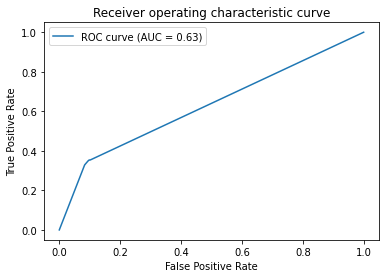

In [8]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()
plot_roc_curve(*evaluate_clf(x_train, y_train, x_test, y_test, clf))

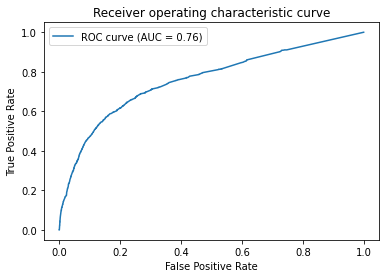

In [10]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
plot_roc_curve(*evaluate_clf(x_train, y_train, x_test, y_test, clf))